ID + Area + Volume

Linear Regression best parameters: {'regressor__fit_intercept': True}
Linear Regression:
  Validation RMSE: 7.78
  Validation MAPE: 14.35%
------
Decision Tree best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4}
Decision Tree:
  Validation RMSE: 8.13
  Validation MAPE: 14.58%
------
Random Forest best parameters: {'regressor__max_features': 2, 'regressor__n_estimators': 30}
Random Forest:
  Validation RMSE: 7.01
  Validation MAPE: 11.85%
------
SVM best parameters: {'regressor__C': 100.0, 'regressor__gamma': 0.1, 'regressor__kernel': 'rbf'}
SVM:
  Validation RMSE: 6.73
  Validation MAPE: 11.80%
------


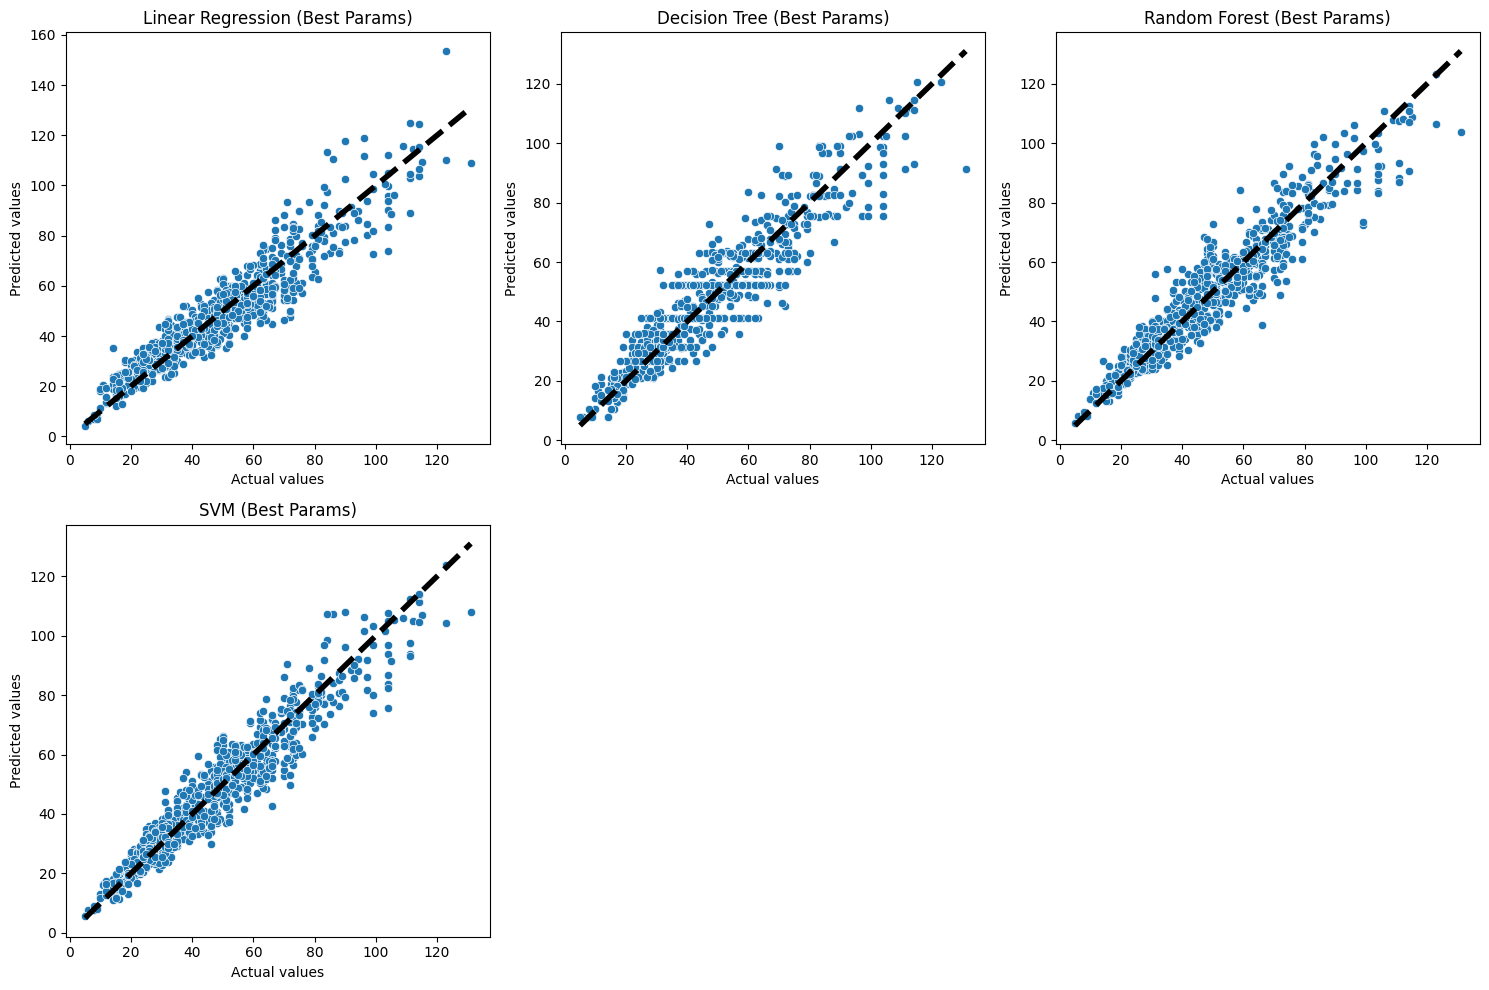

In [132]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Path setup
HOME = os.getcwd()
csv_path = os.path.join(HOME, 'output_with_volume_3.csv')

# Load data
data = pd.read_csv(csv_path)

# Drop rows where 'volume' is NaN or 0
data = data[data['volume'].notna() & (data['volume'] != 0)]

X = data.drop(columns=['mass', 'image_name', 'x_center', 'y_center', 'width', 'height', 'image_area'], axis=1)
y = data['mass'].copy()

# Preprocessing steps
numerical_columns = [col for col in X.columns if col != 'object_id']
categorical_columns = ['object_id']

preprocessor = ColumnTransformer(
    [
        ("one-hot-encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_columns),
        ("standard_scaler", StandardScaler(), numerical_columns),
    ]
)

# Custom split: training (70%), validation (20%), test (10%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, stratify=X[['object_id']])
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.222, shuffle=True, stratify=X_temp[['object_id']])

# Define models and their parameter grids
model_params = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {
            'regressor__fit_intercept': [True, False]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'regressor__max_depth': [None, 10, 20, 30],
            'regressor__min_samples_leaf': [1, 2, 4]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': [
            {'regressor__n_estimators': [3, 10, 30], 'regressor__max_features': [2, 4, 6, 8]},
            {'regressor__bootstrap': [False], 'regressor__n_estimators': [3, 10], 'regressor__max_features': [2, 3, 4]}
        ]
    },
    'SVM': {
        'model': SVR(),
        'params': [
            {'regressor__kernel': ['linear'], 'regressor__C': [10., 100., 1000.]},
            {'regressor__kernel': ['rbf'], 'regressor__C': [1.0, 10., 100., 1000.0], 'regressor__gamma': [0.1, 1.0, 3.0]}
        ]
    }
}

# Function to train and evaluate models with GridSearchCV
def train_and_evaluate(models):
    results = {}
    chosen_model = None
    # chosen_model_name = None
    best_mape = 20
    for name, elements in models.items():
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', elements['model'])
        ])
        model = GridSearchCV(pipeline, elements['params'], cv=5, scoring='neg_mean_squared_error')
        model.fit(X_train, y_train)
        best_model = model.best_estimator_
        train_pred = best_model.predict(X_train)
        val_pred = best_model.predict(X_val)
        test_pred = best_model.predict(X_test)

        # Calculate metrics
        val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        val_mape = mean_absolute_percentage_error(y_val, val_pred)

        results[name] = {
            "val_rmse": val_rmse,
            "val_mape": val_mape,
            "val_pred": val_pred, "best_params": model.best_params_
        }

        if val_mape < best_mape:
          best_mape = val_mape
          chosen_model = model.best_estimator_
          # chosen_model_name = name

        # Print results
        print(f"{name} best parameters: {model.best_params_}")
        print(f"{name}:")
        print(f"  Validation RMSE: {val_rmse:.2f}")
        print(f"  Validation MAPE: {val_mape:.2f}%")
        print("------")

    return results, chosen_model

# Train and evaluate
model_results, best_model = train_and_evaluate(model_params)

# Visualization of Predictions for each model
plt.figure(figsize=(15, 10))
for i, (name, results) in enumerate(model_results.items(), 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=y_val, y=results["val_pred"])
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
    plt.title(f'{name} (Best Params)')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
plt.tight_layout()
plt.show()


Mass Statistics for Each Food Type:
                      food_name  mean_mass   rmse   mape
0     Kabayaki sea bream fillet      50.22   4.38   6.51
1                          Spam      50.56   7.01  10.00
2                apple -sliced-      43.00   3.96   8.27
3                       cabbage      59.87   8.92  13.74
4                   creamy tofu      44.28   6.12  11.45
5   creamy tofu -without sauce-      47.00   6.53  11.69
6                      cucumber      38.78   4.67   9.87
7                      egg tofu      45.33   5.97   8.66
8                     firm tofu      30.21   2.96   9.35
9                     fish cake      32.00   2.79   8.42
10         fried chicken cutlet      74.25   9.31   9.63
11                 fried potato      41.33   6.24  11.99
12                 grilled pork      36.62   4.69  11.76
13               guava -sliced-      45.52   6.38  12.33
14               mustard greens      64.31  11.30  14.34
15               pig blood curd      33.00   4.69  1

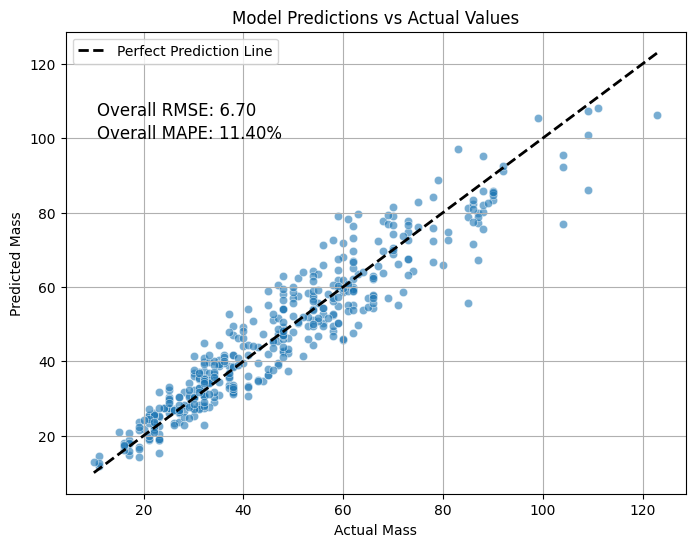

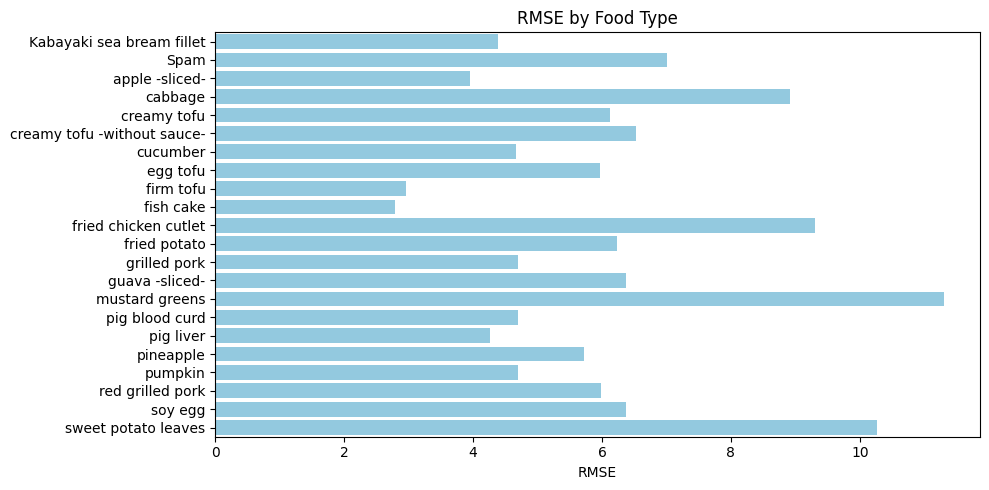

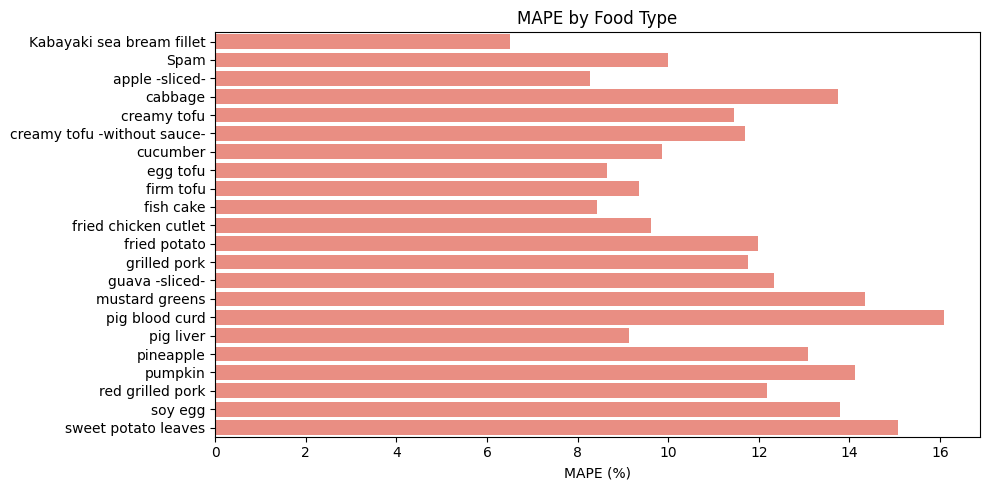

In [133]:
import joblib
joblib.dump(best_model, 'regression_model.pkl')

food_names = ['Kabayaki sea bream fillet', 'Spam', 'apple -sliced-', 'cabbage', 'coin', 'creamy tofu',
              'creamy tofu -without sauce-', 'cucumber', 'egg tofu', 'firm tofu', 'fish cake',
              'fried chicken cutlet', 'fried potato', 'grilled pork', 'guava -sliced-', 'mustard greens',
              'pig blood curd', 'pig liver', 'pineapple', 'pumpkin', 'red grilled pork', 'soy egg',
              'sweet potato leaves']

# Function to calculate RMSE and MAPE for each group
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

test_data = X_test.copy()
test_data['mass'] = y_test

# Group by 'object_id' and calculate mean, RMSE, and MAPE for each food type
food_stats = test_data.groupby('object_id').apply(lambda x: pd.Series({
    'mean_mass': round(x['mass'].mean(), 2),
    'rmse': round(calculate_rmse(y_test.loc[x.index], best_model.predict(X_test.loc[x.index])), 2),
    'mape': round(calculate_mape(y_test.loc[x.index], best_model.predict(X_test.loc[x.index])), 2)
})).reset_index()

# Map object_id back to food names for better readability
food_names_dict = {idx: name for idx, name in enumerate(food_names)}
food_stats['food_name'] = food_stats['object_id'].map(food_names_dict)

# Reorder and display the results
food_stats = food_stats[['food_name', 'mean_mass', 'rmse', 'mape']]
print("Mass Statistics for Each Food Type:")
print(food_stats)

# Generate predictions
y_pred = best_model.predict(X_test)
test_rmse = calculate_rmse(y_test, y_pred)
test_mape = calculate_mape(y_test, y_pred)

# Visualization of Predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction Line')  # Ideal line for perfect predictions
plt.title('Model Predictions vs Actual Values')
plt.xlabel('Actual Mass')
plt.ylabel('Predicted Mass')
plt.grid(True)

# Add text annotations for overall RMSE and MAPE
plt.text(x=0.05, y=0.85, s=f'Overall RMSE: {test_rmse:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(x=0.05, y=0.80, s=f'Overall MAPE: {test_mape:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.legend()

plt.show()


# Plotting RMSE for each food type
plt.figure(figsize=(10, 5))
sns.barplot(x='rmse', y='food_name', data=food_stats, color='skyblue')
plt.title('RMSE by Food Type')
plt.xlabel('RMSE')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Plotting MAPE for each food type
plt.figure(figsize=(10, 5))
sns.barplot(x='mape', y='food_name', data=food_stats, color='salmon')
plt.title('MAPE by Food Type')
plt.xlabel('MAPE (%)')
plt.ylabel('')
plt.tight_layout()
plt.show()


ID + Area

Linear Regression best parameters: {'regressor__fit_intercept': False}
Linear Regression:
  Validation RMSE: 9.02
  Validation MAPE: 16.53%
------
Decision Tree best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4}
Decision Tree:
  Validation RMSE: 9.39
  Validation MAPE: 16.50%
------
Random Forest best parameters: {'regressor__max_features': 8, 'regressor__n_estimators': 30}
Random Forest:
  Validation RMSE: 9.31
  Validation MAPE: 15.13%
------
SVM best parameters: {'regressor__C': 1000.0, 'regressor__gamma': 0.1, 'regressor__kernel': 'rbf'}
SVM:
  Validation RMSE: 8.13
  Validation MAPE: 13.63%
------


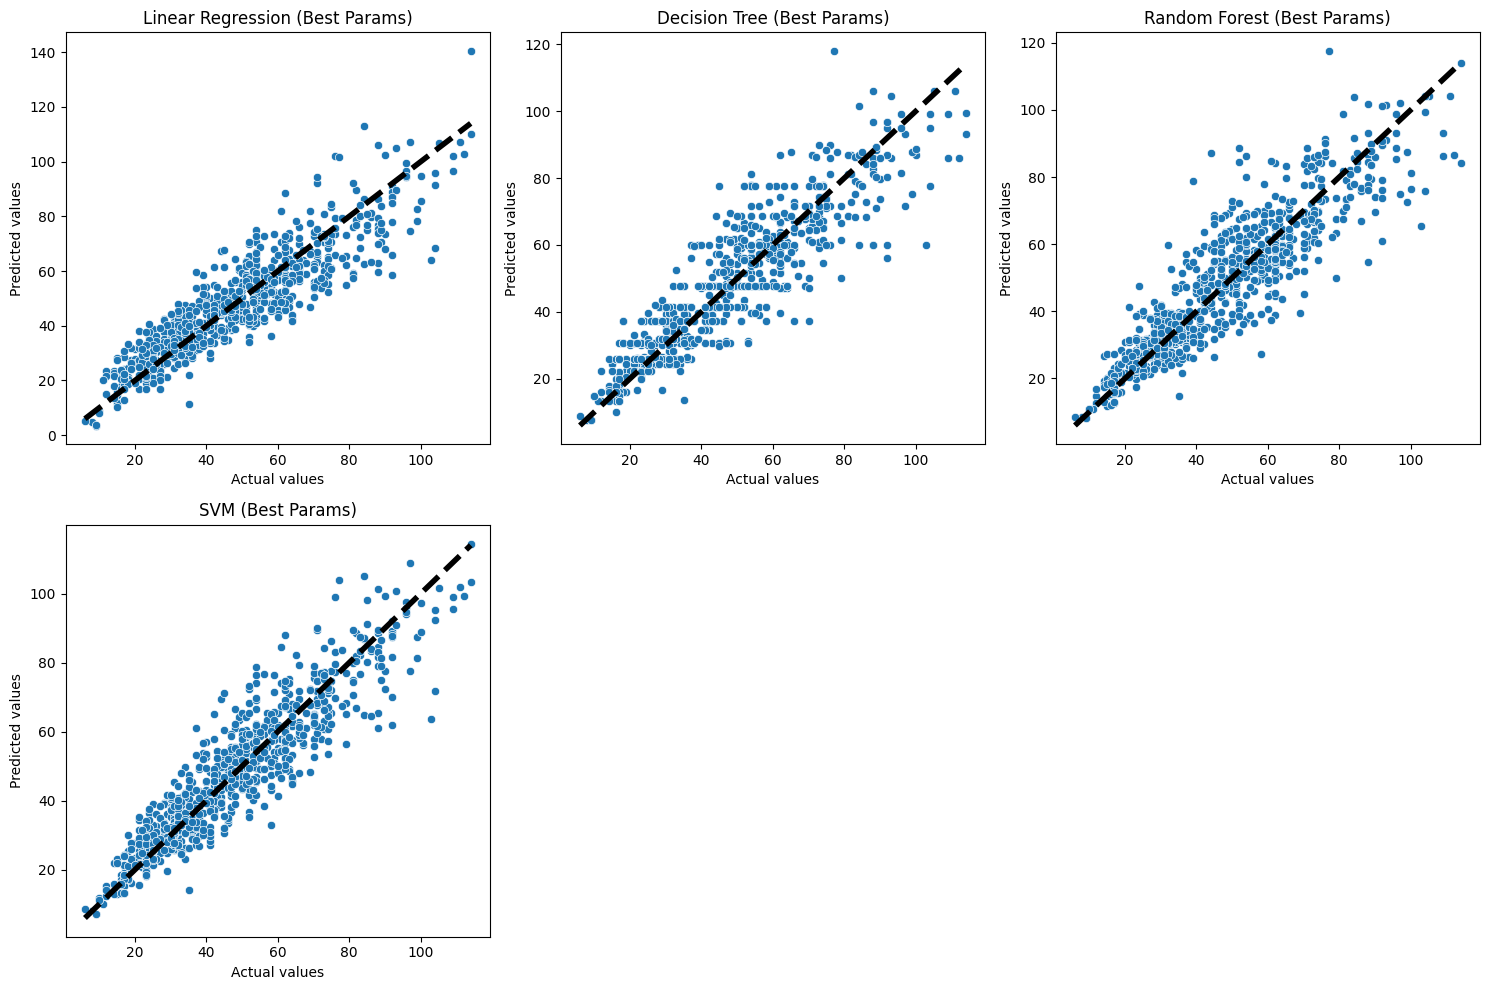

In [ ]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Path setup
HOME = os.getcwd()
csv_path = os.path.join(HOME, 'output_with_volume_3.csv')

# Load data
data = pd.read_csv(csv_path)

# Drop rows where 'volume' is NaN or 0
data = data[data['volume'].notna() & (data['volume'] != 0)]

X = data.drop(columns=['mass', 'image_name', 'x_center', 'y_center', 'width', 'height', 'image_area', 'volume'], axis=1)
y = data['mass'].copy()

# Preprocessing steps
numerical_columns = [col for col in X.columns if col != 'object_id']
categorical_columns = ['object_id']

preprocessor = ColumnTransformer(
    [
        ("one-hot-encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_columns),
        ("standard_scaler", StandardScaler(), numerical_columns),
    ]
)

# Custom split: training (70%), validation (20%), test (10%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, stratify=X[['object_id']])
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.222, shuffle=True, stratify=X_temp[['object_id']])

# Define models and their parameter grids
model_params = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {
            'regressor__fit_intercept': [True, False]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'regressor__max_depth': [None, 10, 20, 30],
            'regressor__min_samples_leaf': [1, 2, 4]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': [
            {'regressor__n_estimators': [3, 10, 30], 'regressor__max_features': [2, 4, 6, 8]},
            {'regressor__bootstrap': [False], 'regressor__n_estimators': [3, 10], 'regressor__max_features': [2, 3, 4]}
        ]
    },
    'SVM': {
        'model': SVR(),
        'params': [
            {'regressor__kernel': ['linear'], 'regressor__C': [10., 100., 1000.]},
            {'regressor__kernel': ['rbf'], 'regressor__C': [1.0, 10., 100., 1000.0], 'regressor__gamma': [0.1, 1.0, 3.0]}
        ]
    }
}

# Function to train and evaluate models with GridSearchCV
def train_and_evaluate(models):
    results = {}
    # chosen_model_name = None
    best_mape = 20
    for name, elements in models.items():
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', elements['model'])
        ])
        model = GridSearchCV(pipeline, elements['params'], cv=5, scoring='neg_mean_squared_error')
        model.fit(X_train, y_train)
        best_model = model.best_estimator_
        train_pred = best_model.predict(X_train)
        val_pred = best_model.predict(X_val)
        test_pred = best_model.predict(X_test)

        # Calculate metrics
        val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        val_mape = mean_absolute_percentage_error(y_val, val_pred)

        results[name] = {
            "val_rmse": val_rmse,
            "val_mape": val_mape,
            "val_pred": val_pred, "best_params": model.best_params_
        }

        if val_mape < best_mape:
          best_mape = val_mape
          # chosen_model_name = name

        # Print results
        print(f"{name} best parameters: {model.best_params_}")
        print(f"{name}:")
        print(f"  Validation RMSE: {val_rmse:.2f}")
        print(f"  Validation MAPE: {val_mape:.2f}%")
        print("------")

    return results

# Train and evaluate
model_results = train_and_evaluate(model_params)

# Visualization of Predictions for each model
plt.figure(figsize=(15, 10))
for i, (name, results) in enumerate(model_results.items(), 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=y_val, y=results["val_pred"])
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
    plt.title(f'{name} (Best Params)')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
plt.tight_layout()
plt.show()


ID + Volume

Linear Regression best parameters: {'regressor__fit_intercept': True}
Linear Regression:
  Validation RMSE: 8.78
  Validation MAPE: 15.67%
------
Decision Tree best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4}
Decision Tree:
  Validation RMSE: 8.94
  Validation MAPE: 15.07%
------
Random Forest best parameters: {'regressor__max_features': 8, 'regressor__n_estimators': 30}
Random Forest:
  Validation RMSE: 9.01
  Validation MAPE: 14.46%
------
SVM best parameters: {'regressor__C': 100.0, 'regressor__gamma': 1.0, 'regressor__kernel': 'rbf'}
SVM:
  Validation RMSE: 8.07
  Validation MAPE: 13.14%
------


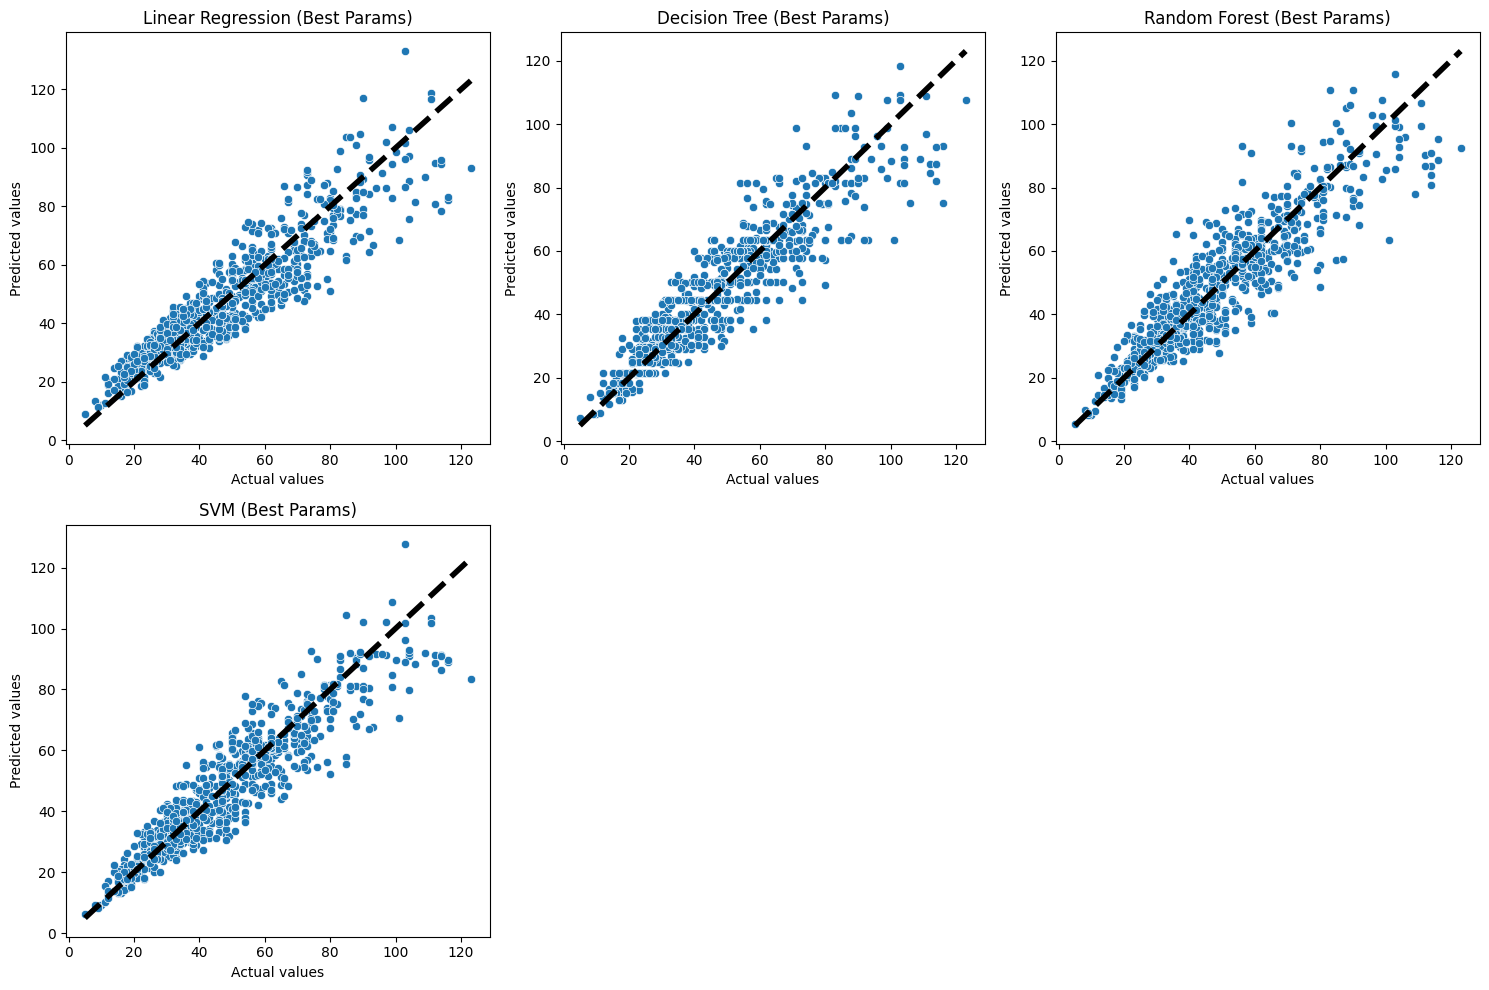

In [ ]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

# Define a function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Path setup
HOME = os.getcwd()
csv_path = os.path.join(HOME, 'output_with_volume_3.csv')

# Load data
data = pd.read_csv(csv_path)

# Drop rows where 'volume' is NaN or 0
data = data[data['volume'].notna() & (data['volume'] != 0)]

X = data.drop(columns=['mass', 'image_name', 'x_center', 'y_center', 'width', 'height', 'image_area', 'area'], axis=1)
y = data['mass'].copy()

# Preprocessing steps
numerical_columns = [col for col in X.columns if col != 'object_id']
categorical_columns = ['object_id']

preprocessor = ColumnTransformer(
    [
        ("one-hot-encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_columns),
        ("standard_scaler", StandardScaler(), numerical_columns),
    ]
)

# Custom split: training (70%), validation (20%), test (10%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, stratify=X[['object_id']])
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.222, shuffle=True, stratify=X_temp[['object_id']])

# Define models and their parameter grids
model_params = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {
            'regressor__fit_intercept': [True, False]
        }
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'regressor__max_depth': [None, 10, 20, 30],
            'regressor__min_samples_leaf': [1, 2, 4]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': [
            {'regressor__n_estimators': [3, 10, 30], 'regressor__max_features': [2, 4, 6, 8]},
            {'regressor__bootstrap': [False], 'regressor__n_estimators': [3, 10], 'regressor__max_features': [2, 3, 4]}
        ]
    },
    'SVM': {
        'model': SVR(),
        'params': [
            {'regressor__kernel': ['linear'], 'regressor__C': [10., 100., 1000.]},
            {'regressor__kernel': ['rbf'], 'regressor__C': [1.0, 10., 100., 1000.0], 'regressor__gamma': [0.1, 1.0, 3.0]}
        ]
    }
}

# Function to train and evaluate models with GridSearchCV
def train_and_evaluate(models):
    results = {}
    # chosen_model_name = None
    best_mape = 20
    for name, elements in models.items():
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', elements['model'])
        ])
        model = GridSearchCV(pipeline, elements['params'], cv=5, scoring='neg_mean_squared_error')
        model.fit(X_train, y_train)
        best_model = model.best_estimator_
        train_pred = best_model.predict(X_train)
        val_pred = best_model.predict(X_val)
        test_pred = best_model.predict(X_test)

        # Calculate metrics
        val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        val_mape = mean_absolute_percentage_error(y_val, val_pred)

        results[name] = {
            "val_rmse": val_rmse,
            "val_mape": val_mape,
            "val_pred": val_pred, "best_params": model.best_params_
        }

        if val_mape < best_mape:
          best_mape = val_mape
          # chosen_model_name = name

        # Print results
        print(f"{name} best parameters: {model.best_params_}")
        print(f"{name}:")
        print(f"  Validation RMSE: {val_rmse:.2f}")
        print(f"  Validation MAPE: {val_mape:.2f}%")
        print("------")

    return results

# Train and evaluate
model_results = train_and_evaluate(model_params)

# Visualization of Predictions for each model
plt.figure(figsize=(15, 10))
for i, (name, results) in enumerate(model_results.items(), 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=y_val, y=results["val_pred"])
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
    plt.title(f'{name} (Best Params)')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
plt.tight_layout()
plt.show()
